In [116]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [117]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [118]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [119]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(list(dataset))  # Convert the dataset to a list and get its length

    train_size = int(TRAIN_RATIO * DATASET_SIZE)
    val_size = int(VAL_RATIO * DATASET_SIZE)
    test_size = int(TEST_RATIO * DATASET_SIZE)

    train_dataset = dataset.take(train_size)
    val_test_dataset = dataset.skip(train_size)

    val_dataset = val_test_dataset.take(val_size)
    test_dataset = val_test_dataset.skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [120]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1


train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

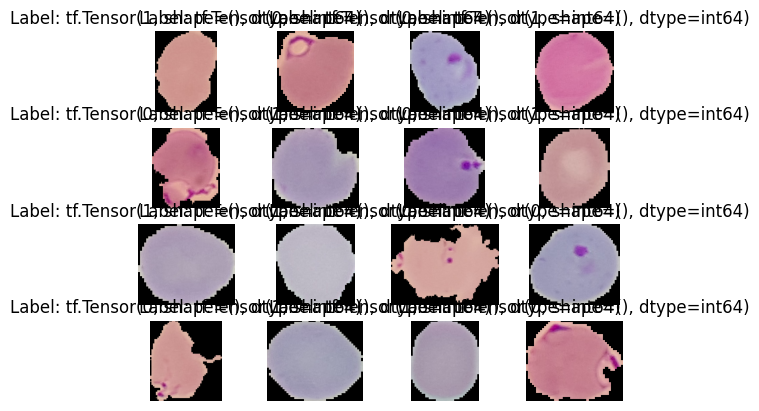

In [121]:
import matplotlib.pyplot as plt

for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title("Label: " + str(label))  # Set the title with the label as a string
    plt.axis('off')
plt.show()


In [122]:
IM_SIZE = 224
def resizing_rescale(image, label):
    return tf.image.resize(image,(IM_SIZE, IM_SIZE))/225.0, label

In [123]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)

In [124]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [125]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [126]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [127]:
##LeNet Model
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu' ),
    BatchNormalization(),
    MaxPool2D(pool_size= 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu' ),
    BatchNormalization(),
    MaxPool2D(pool_size= 2, strides = 2),

    Flatten(),

    Dense(100, activation= "relu"),
    BatchNormalization(),
    Dense(10, activation= "relu"),
    BatchNormalization(),
    Dense(1, activation= "sigmoid")
])
lenet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [128]:
lenet_model.compile(optimizer= Adam(learning_rate = 0.1),
             loss = BinaryCrossentropy(),
             metrics = 'accuracy')

In [129]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [130]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
 history = lenet_model.fit(train_dataset, validation_data = val_dataset, epochs = 20, verbose = 1)

Epoch 1/20
689/689 [==============================] - 51s 74ms/step - loss: 0.1764 - accuracy: 0.9445 - val_loss: 0.1981 - val_accuracy: 0.9372
Epoch 2/20
689/689 [==============================] - 53s 77ms/step - loss: 0.1685 - accuracy: 0.9476 - val_loss: 0.6515 - val_accuracy: 0.5993
Epoch 3/20
689/689 [==============================] - 45s 65ms/step - loss: 0.1569 - accuracy: 0.9521 - val_loss: 0.2527 - val_accuracy: 0.9281
Epoch 4/20
689/689 [==============================] - 44s 64ms/step - loss: 0.1481 - accuracy: 0.9524 - val_loss: 0.2266 - val_accuracy: 0.9408
Epoch 5/20
689/689 [==============================] - 45s 66ms/step - loss: 0.1382 - accuracy: 0.9553 - val_loss: 0.7566 - val_accuracy: 0.8377
Epoch 6/20
689/689 [==============================] - 44s 63ms/step - loss: 0.1428 - accuracy: 0.9536 - val_loss: 0.1826 - val_accuracy: 0.9430
Epoch 7/20
689/689 [==============================] - 57s 83ms/step - loss: 0.1186 - accuracy: 0.9599 - val_loss: 0.3111 - val_accuracy:

<function matplotlib.pyplot.show(close=None, block=None)>

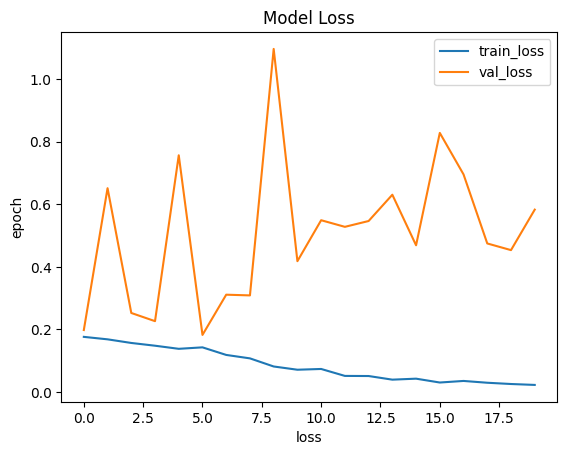

In [132]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

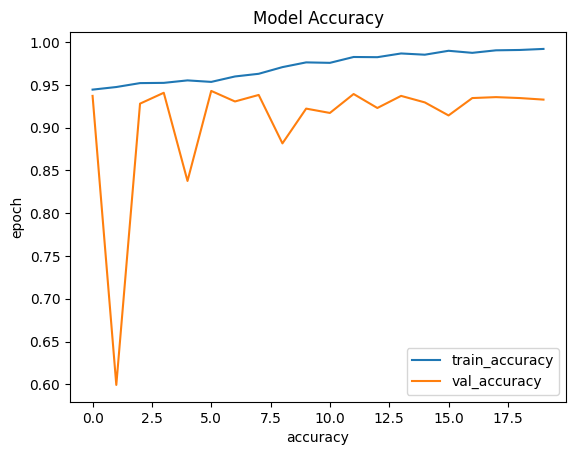

In [133]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('accuracy')
plt.ylabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show

In [134]:
test_dataset = test_dataset.batch(1)

In [135]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 24s 5ms/step - loss: 0.6966 - accuracy: 0.4889


[0.6966302394866943, 0.48893725872039795]

In [136]:
def parasite_or_not(x):
  if(x<0.5):
    return str('Parasitized.')
  else:
    return str('Not Parasitized.')

In [137]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 12s 12s/step


'Not Parasitized.'

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


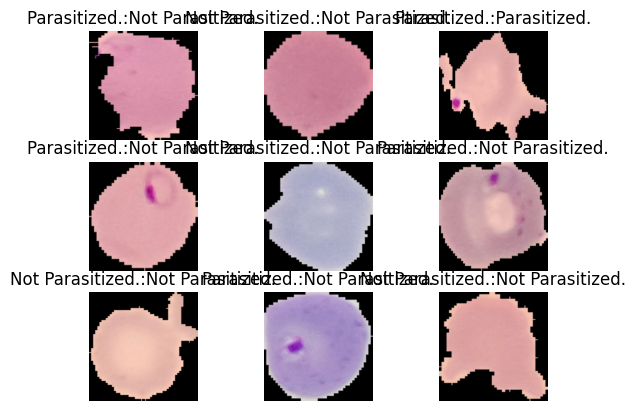

In [138]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3,3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))

  plt.axis('off')

In [139]:
lenet_model.save("lenet")

In [140]:
lenet_loaded_model = tf.keras.models.load_model("lenet")
lenet_loaded_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
!cp -r /content/lenet/ /content/drive/MyDrive/lenet_colab/

In [143]:
!cp -r /content/drive/MyDrive/lenet_colab/ /content/lenet_colab/